In [2]:
!pip install git+https://github.com/forrestbao/pyeeg.git

import pandas as pd
import keras.backend as K
import numpy as np
import pandas as pd
import pyeeg as pe
import pickle as pickle
import math
from sklearn import svm
from sklearn.preprocessing import normalize

import os
import time

  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-zgp42c45
  Running command git clone -q https://github.com/forrestbao/pyeeg.git /tmp/pip-req-build-zgp42c45
  Created wheel for pyeeg: filename=pyeeg-0.4.4-py2.py3-none-any.whl size=28123 sha256=60a62195b5c49ddff14cf63ba2a79acdccfd295dad3fe2b617b7000fae2470f1
  Stored in directory: /tmp/pip-ephem-wheel-cache-99yz75rr/wheels/2d/3f/ad/106d4fc80b61d1ea1fc18e76e7439fd98aa043d83d58eae741
Successfully built pyeeg


In [3]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers.convolutional import Convolution1D, MaxPooling1D, ZeroPadding1D,Conv1D
from keras.models import Sequential
from keras.utils import to_categorical 

from keras.models import Model
import timeit
from keras.optimizers import SGD

import warnings
warnings.filterwarnings('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Opening data

In [5]:
with open('/content/drive/MyDrive/Colab Notebooks/DEAP  - saved/data_training.npy', 'rb') as fileX_training:
    X_train  = np.load(fileX_training)
    
with open('/content/drive/MyDrive/Colab Notebooks/DEAP  - saved/label_training.npy', 'rb') as fileY_training:
    Y_train  = np.load(fileY_training)   


In [8]:
X_train = normalize(X_train)
Z_train = np.ravel(Y_train[:, [1]])  # valence
#labels
train_arousal = np.ravel(Y_train[:, [0]])
train_valence = np.ravel(Y_train[:, [1]])
train_dominance = np.ravel(Y_train[:, [2]])
train_liking = np.ravel(Y_train[:, [3]])

In [9]:
from keras.utils import to_categorical
y_train = to_categorical(Z_train)
x_train = np.array(X_train[:])

In [10]:
with open('/content/drive/MyDrive/Colab Notebooks/DEAP  - saved/data_testing.npy', 'rb') as fileX_training:
    X_test  = np.load(fileX_training)
    
with open('/content/drive/MyDrive/Colab Notebooks/DEAP  - saved/label_testing.npy', 'rb') as fileY_training:
    Y_test  = np.load(fileY_training)


In [11]:
X_test = normalize(X_test)
Z_test = np.ravel(Y_test[:, [1]]) # valence

test_arousal = np.ravel(Y_test[:, [0]])
test_valence = np.ravel(Y_test[:, [1]])
test_dominance = np.ravel(Y_test[:, [2]])
test_liking = np.ravel(Y_test[:, [3]])

In [12]:
x_test = np.array(X_test[:])

In [13]:
from keras.utils import to_categorical
y_test = to_categorical(Z_test)
y_test

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [14]:
y_test[1]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [15]:
from sklearn.preprocessing import StandardScaler
temp = StandardScaler()
x_train = temp.fit_transform(x_train)
x_test = temp.fit_transform(x_test)

In [16]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1], 1)
classes = 10
shape=(x_train.shape[1], 1)
print(shape)

(70, 1)


# CNN + RNN model

In [17]:

from keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D, BatchNormalization, Activation, Dropout, Flatten, Dense
from keras.regularizers import l2
from keras.layers import Bidirectional
from keras.layers import LSTM


model_mix = Sequential()

# Using CNN layers
model_mix.add(Conv1D(128, kernel_size=3,padding = 'same',activation='relu',input_shape=shape))
model_mix.add(BatchNormalization())
model_mix.add(MaxPooling1D(pool_size=(2)))

model_mix.add(Conv1D(128,kernel_size=(3),padding = 'same', activation='relu'))
model_mix.add(BatchNormalization())
model_mix.add(MaxPooling1D(pool_size=(2)))

# Using RNN(LSTM) layers
model_mix.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=shape))
model_mix.add(Dropout(0.6))

model_mix.add(LSTM(units = 256, return_sequences = True))  
model_mix.add(Dropout(0.6))

model_mix.add(LSTM(units = 64, return_sequences = True))  
model_mix.add(Dropout(0.6))

model_mix.add(Flatten())

# simple dense layers
model_mix.add(Dense(64, activation='relu'))
model_mix.add(Dropout(0.2))
model_mix.add(Dense(32, activation='relu'))
model_mix.add(Dropout(0.2))
model_mix.add(Dense(16, activation='relu'))
model_mix.add(Dropout(0.2))
model_mix.add(Dense(classes, activation='softmax'))
model_mix.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 70, 128)           512       
_________________________________________________________________
batch_normalization (BatchNo (None, 70, 128)           512       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 35, 128)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 35, 128)           49280     
_________________________________________________________________
batch_normalization_1 (Batch (None, 35, 128)           512       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 17, 128)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 17, 256)           2

In [18]:
model_mix.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [20]:
iter = 50

In [21]:

m=model_mix.fit(x_train, y_train,batch_size=256,epochs=iter,  verbose=1,validation_data=(x_test,y_test))

Epoch 1/50
179/179 [==============================] - 149s 790ms/step - loss: 2.2007 - accuracy: 0.1737 - val_loss: 2.2701 - val_accuracy: 0.1967
Epoch 2/50
179/179 [==============================] - 139s 775ms/step - loss: 2.0022 - accuracy: 0.2500 - val_loss: 2.1728 - val_accuracy: 0.2544
Epoch 3/50
179/179 [==============================] - 141s 788ms/step - loss: 1.9229 - accuracy: 0.2711 - val_loss: 1.8531 - val_accuracy: 0.3084
Epoch 4/50
179/179 [==============================] - 139s 779ms/step - loss: 1.8744 - accuracy: 0.2856 - val_loss: 1.7449 - val_accuracy: 0.3388
Epoch 5/50
179/179 [==============================] - 140s 782ms/step - loss: 1.8087 - accuracy: 0.3220 - val_loss: 1.8329 - val_accuracy: 0.3443
Epoch 6/50
179/179 [==============================] - 139s 775ms/step - loss: 1.7543 - accuracy: 0.3471 - val_loss: 1.6425 - val_accuracy: 0.3818
Epoch 7/50
179/179 [==============================] - 138s 772ms/step - loss: 1.6783 - accuracy: 0.3729 - val_loss: 1.5478 -

In [22]:
model_score = model_mix.evaluate(x_test, y_test, verbose=1)
print('Test loss:', model_score[0])
print('Test accuracy:', model_score[1])

357/357 [==============================] - 16s 46ms/step - loss: 0.8836 - accuracy: 0.8074
Test loss: 0.8836345672607422
Test accuracy: 0.8073723912239075


In [24]:
# list all data in history
print(m.history.keys())
import matplotlib.pyplot as plt
import numpy


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


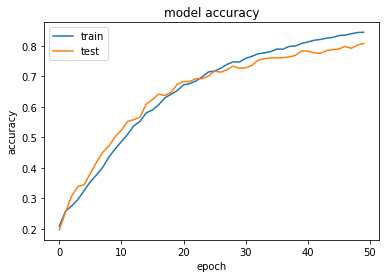

In [25]:
# summarize history for accuracy
plt.plot(m.history['accuracy'])
plt.plot(m.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

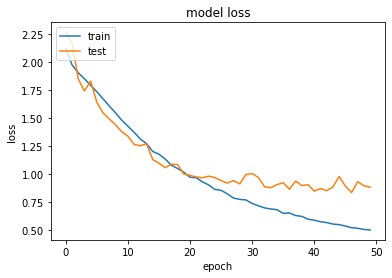

In [26]:
# summarize history for loss
plt.plot(m.history['loss'])
plt.plot(m.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

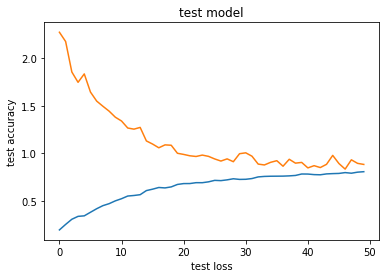

In [27]:
plt.plot(m.history['val_accuracy'])
plt.plot(m.history['val_loss'])
plt.title('test model')
plt.ylabel('test accuracy')
plt.xlabel('test loss')
plt.show()

In [28]:
y_pred=model_mix.predict(x_test)
from sklearn.metrics import confusion_matrix
import numpy as np

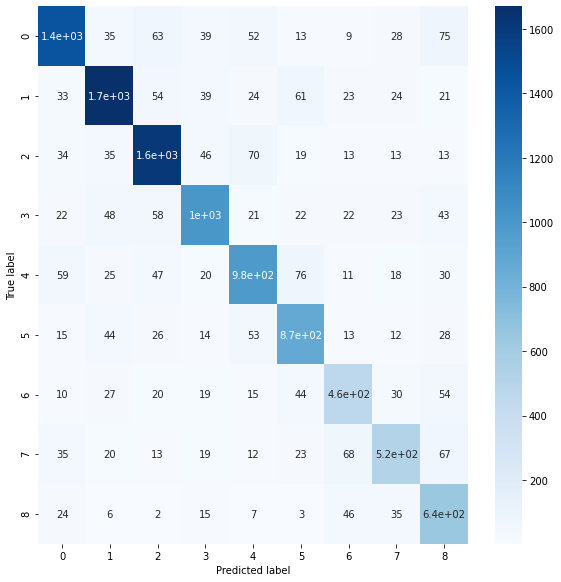

In [29]:
y_test[1]
y_pred[1]
y_test1=np.argmax(y_test, axis=1)
y_pred=np.argmax(y_pred,axis=1)
cmatrix=confusion_matrix(y_test1, y_pred)
import seaborn as sns
figure = plt.figure(figsize=(8, 8))
sns.heatmap(cmatrix, annot=True,cmap=plt.cm.Blues)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# ROC Curve

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score

In [31]:
# make probability predictions with the model
predictions = model_mix.predict(x_test)
# round predictions 
rounded = [round(x[0]) for x in predictions]
rounded = np.array(rounded)
rounded.shape

(11421,)

In [32]:
# make class predictions with the model
predictions = model_mix.predict_classes(x_test)

In [33]:
temp = label_binarize(predictions,classes = [0,1,2,3,4,5,6,7,8,9] )
temp
temp1 = label_binarize(y_test,classes = [0,1,2,3,4,5,6,7,8,9] )
temp1

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [34]:
false_pr = dict()
true_pr = dict()
roc_auc = dict()
for i in range(classes-1):
    false_pr[i], true_pr[i], _ = roc_curve(temp1[:, i], temp[:, i])
    roc_auc[i] = auc(false_pr[i], true_pr[i])

false_pr["micro"], true_pr["micro"], _ = roc_curve(temp1.ravel(), temp.ravel())
roc_auc["micro"] = auc(false_pr["micro"], true_pr["micro"])

In [35]:
classes = classes  -1
lw = 2

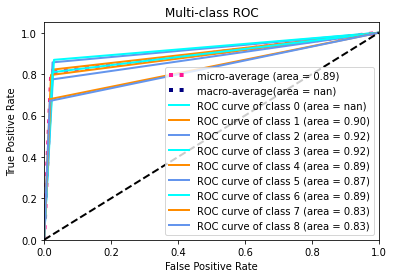

In [36]:
combined_fpr = np.unique(np.concatenate([false_pr[i] for i in range(classes)]))

# Then interpolate all ROC curves at this points
average_tpr = np.zeros_like(combined_fpr)
for i in range(classes):
    average_tpr += interp(combined_fpr, false_pr[i], true_pr[i])

average_tpr /= (classes)

false_pr["macro"] = combined_fpr
true_pr["macro"] = average_tpr
roc_auc["macro"] = auc(false_pr["macro"], true_pr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(false_pr["micro"], true_pr["micro"],
         label='micro-average (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(false_pr["macro"], true_pr["macro"],
         label='macro-average(area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(classes), colors):
    plt.plot(false_pr[i], true_pr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC')
plt.legend(loc="lower right")
plt.show()

In [37]:
cm = cmatrix
cm

array([[1446,   35,   63,   39,   52,   13,    9,   28,   75],
       [  33, 1670,   54,   39,   24,   61,   23,   24,   21],
       [  34,   35, 1613,   46,   70,   19,   13,   13,   13],
       [  22,   48,   58, 1010,   21,   22,   22,   23,   43],
       [  59,   25,   47,   20,  983,   76,   11,   18,   30],
       [  15,   44,   26,   14,   53,  870,   13,   12,   28],
       [  10,   27,   20,   19,   15,   44,  465,   30,   54],
       [  35,   20,   13,   19,   12,   23,   68,  523,   67],
       [  24,    6,    2,   15,    7,    3,   46,   35,  641]])

In [38]:
recall = np.diag(cm) / np.sum(cm, axis = 1)
precision = np.diag(cm) / np.sum(cm, axis = 0)

In [40]:
print("Recall",np.nanmean(recall))
print("precision",np.nanmean(precision))

Recall 0.7889479267972309
precision 0.7857998103354055
